# Avellaneda-Stoikov Model - Part1

```{note}
Avellaneda-Stoikov 模型是一种用于高频交易（HFT）中的做市策略模型，旨在为做市商提供动态调整买卖报价的方法，以实现盈利最大化。
```

Paper: https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf

## The mid-price of the stock

For simplicity, we assume the mid-market price, or mid-price, of the stock evolves according to:

$$\mathrm{d}S_{u} = \sigma\mathrm{d}W_{u}$$

with initial value $S_{t}=s$. Here $W_{t}$ is a standard one-dimensional
Brownian motion (一维布朗运动) and $\sigma$ is constant (波动率).

```{tip}
![](images/brownian.png)
```

$$S_{T}-S_{t}\sim\mathcal{N}(0,\,\sigma^{2}(T-t))$$

In [1]:
from utils import *

lst = read_jsonl('2024-05-29.json')
show_list(lst)

86400
[1716912000000, '3861.10000000', '3861.11000000', '3861.10000000', '3861.11000000', '0.36010000', 1716912000999, '1390.38375800', 21, '0.16480000', '636.31092800', '0']


In [2]:
import numpy as np

def estimate_sigma(offset: int):
    nums = []
    for i in range(offset, len(lst)):
        nums.append(float(lst[i][1]) - float(lst[i-offset][1]))
    variance = np.var(nums)
    sigma = (variance / offset) ** 0.5
    return sigma

for offset in [1, 2, 3, 5, 10, 30, 100, 1000, 10000]:
    print(offset, estimate_sigma(offset=offset))
    

1 0.3145904485168454
2 0.32797930610480586
3 0.33733973643324583
5 0.3466411808627137
10 0.3549214218136544
30 0.3646490686485507
100 0.3642004554245304
1000 0.37564767614940037
10000 0.3082733215942566


## The optimizing agent with finite-horizon

The agent’s objective is to maximize the expected
exponential utility of his P&L profile at a terminal
time $T$.

We first model an inactive trader who does not have
any limit orders in the market and simply holds an
inventory of $q$ stocks until the terminal time $T$. The agent's value function (效用函数) is

$$
v(x,s,q,t) = \mathbb{E}_{t}[-\exp(-\gamma(x+qS_{T}))]$$

where $x$ is the initial wealth in dollars.

```{tip}
![](images/as.png)
```

![](images/as1.svg)

This value function
can be written as:

$$v(x, s, q, t) = -\exp(-\gamma x)\exp(-\gamma qs)\exp\left(\frac{\gamma^{2}q^{2}\sigma^{2}(T-t)}{2}\right)$$

```{tip}
Proof:<br>
![](images/as2.png)
```

We may now define the reservation bid and ask prices
for the agent. The reservation bid price is the price that
would make the agent indifferent between his current
portfolio and his current portfolio plus one stock.
The reservation ask price is defined similarly below. (以 reservation bid price 买入1股票满意度不变)

**Definition 1**. Let $v$ be the value function of the agent. His reservation bid price $r^{b}$ is given implicitly by the relation:

$$v(x-r^{b}(s, q, t), s, q+1, t) = v(x, s, q, t)$$

The reservation ask price $r^{a}$ solves:

$$v(x+r^{a}(s, q, t), s, q-1, t) = v(x, s, q, t)$$

A simple computation yields a closed-form expression for the two prices:

$$r^{b}(s, q, t) = s + (-1-2q)\frac{\gamma\sigma^{2}(T-t)}{2}$$

$$r^{a}(s, q, t) = s + (1-2q)\frac{\gamma\sigma^{2}(T-t)}{2}$$

in the setting where no trading is allowed. We will refer to
the average of these two prices as the reservation or
indifference price

$$r(s, q, t) = s - q\gamma\sigma^{2}(T-t)$$

given that the agent is holding $q$ stocks.

```{note}
This price is an
adjustment to the mid-price, which accounts for the
inventory held by the agent. If the agent is long stock
$(q>0)$, the reservation price is below the mid-price,
indicating a desire to liquidate the inventory by selling
stock. On the other hand, if the agent is short stock
$(q<0)$, the reservation price is above the mid-price, since
the agent is willing to buy stock at a higher price.
```

```{tip}
$$v(x-r^{\Delta{q}}(s, q, t)\Delta{q}, s, q+\Delta{q}, t) = v(x, s, q, t)$$

leed to:

$$r^{\Delta{q}}(s, q, t) = s + (-\Delta{q}-2q)\frac{\gamma\sigma^{2}(T-t)}{2}$$

so we have:

$$\frac{r^{\Delta{q}}(s, q, t) + r^{-\Delta{q}}(s, q, t)}{2} = s - q\gamma\sigma^{2}(T-t)$$
```

In [3]:
prices = [float(item[1]) for item in lst]

def get_indifference_price(q, gamma, sigma):
    result = []
    for i, price in enumerate(prices):
        # terminal every 8 hours
        time_diff = (86400 - i - 1) % (60 * 60 * 8)
        result.append(price - q * gamma * (sigma ** 2) * time_diff)
    return result

l1 = get_indifference_price(q=1, gamma=0.01, sigma=0.3)

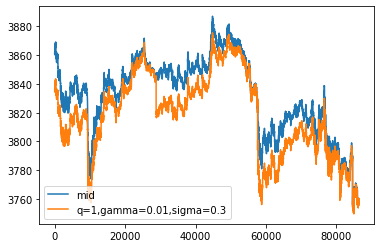

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.arange(len(lst)), prices, label='mid')
plt.plot(np.arange(len(lst)), l1, label='q=1,gamma=0.01,sigma=0.3')
plt.legend()
plt.show()

```{note}
When $q>\frac{1}{2}$:

* If buy at mid price $s$, inventory from $q$ to $q+1$, more risky, lower the buy price!

* If sell at mid price $s$, inventory from $q$ to $q-1$, release inventory pressure, willing to accept lower sell price.
```